In [21]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
import yfinance as yf
import matplotlib.pyplot as plt
import copy



In [22]:
# 1. Environment
class TradingEnv(gym.Env):
    def __init__(self, df, initial_balance=100000):
        super(TradingEnv, self).__init__()
        
        self.df = df
        
        self.current_step = 0

        self.initial_price = df.iloc[0]['Close']

        self.initial_portfolio_value = initial_balance
        
        # Action space: 0 (sell), 1 (hold), 2 (buy)
        self.action_space = spaces.Discrete(3)
        
        # Observation space: price data + account info
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(8,), dtype=np.float32)
        self.max_shares_held = initial_balance / self.initial_price

        self.initial_shares_held = int(initial_balance / (2*self.initial_price))
        self.initial_balance = initial_balance - self.initial_shares_held * self.initial_price

        self.trading_rate = 0.2
        self.trading_cost = 0.003
        
        self.reset()
        
    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = self.initial_shares_held
        self.cost_basis = 0
        self.total_trades = 1
        self.total_profit = 0
        return self._get_observation()
    
    def _get_observation(self):
        # Get current price data
        current_price = self.df.iloc[self.current_step]['Close']
        
        
        # Calculate technical indicators
        rsi = self.df.iloc[self.current_step]['RSI']
        ma_ratio = self.df.iloc[self.current_step]['MA_ratio']
        volatility = self.df.iloc[self.current_step]['Volatility']
        
        # Portfolio info
        portfolio_value = self.balance + (self.shares_held * current_price)
        profit_pct = (portfolio_value - self.initial_portfolio_value) / self.initial_portfolio_value

        self.max_shares_held = portfolio_value / current_price
        
        # Create observation as a numpy array
        obs = np.array([
            current_price / self.df['Close'].mean() - 1,  # Normalized price
            self.balance / self.initial_portfolio_value - 1,  # Normalized balance
            self.shares_held * current_price / self.initial_portfolio_value,  # Position size
            profit_pct,
            rsi / 100 - 0.5,  # Normalized RSI
            ma_ratio - 1,  # MA ratio
            volatility,
            self.total_trades / 100  # Normalized trade count
        ])
        
        # Ensure the observation is a numpy array of type float32
        return obs.astype(np.float32)
    
    def step(self, action):
        current_price = self.df.iloc[self.current_step]['Close']
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1

        initial_portfolio_value = self.balance + (self.shares_held * current_price)
        
        # Execute trade
        reward = 0

        max_shares = int(initial_portfolio_value / (current_price))
        shares_to_trade = max_shares * self.trading_rate

        if action == 0:  # Sell
            if shares_to_trade < self.shares_held:
                # Sell all shares
                
                self.balance += shares_to_trade * current_price * (1 - self.trading_cost)  # 0.3% transaction cost
                reward = (current_price - self.cost_basis) * self.shares_held / self.initial_portfolio_value
                self.shares_held = self.shares_held - shares_to_trade
                self.total_trades += 1
            else:
                reward -= 1
            if self.total_trades > self.current_step / 3:  # More than 1 trade per 10 steps
                reward -= 5 * np.log(self.total_trades/ (self.current_step / 3))
                
        elif action == 2:  # Buy
            if self.balance > shares_to_trade * current_price:
                # Calculate maximum shares we can buy
                if shares_to_trade > 0:
                    self.shares_held += shares_to_trade
                    self.balance -= shares_to_trade * current_price * (1 + self.trading_cost)
                    self.cost_basis = current_price
                    self.total_trades += 1
                else:
                    reward -= 1
            if self.total_trades > self.current_step / 3:  # More than 1 trade per 10 steps
                reward -= 5 * np.log(self.total_trades/ (self.current_step / 3))
        
        # Calculate portfolio value and return
        portfolio_value = self.balance + (self.shares_held * current_price)
        profit = portfolio_value - self.initial_portfolio_value
        self.total_profit = profit
        
        # Calculate reward
        reward += profit / self.initial_portfolio_value
        
        # Add trading frequency penalty
        
        
        info = {
            'portfolio_value': portfolio_value,
            'profit': profit,
            'trades': self.total_trades,
            'shares_held': self.shares_held,
            'max_shares_held': self.max_shares_held
        }
        
        return self._get_observation(), reward, done, info

In [36]:
10//4
10%4

2

In [39]:
class MultiStockTradingEnv(gym.Env):
    def __init__(self, data_dict, initial_balance=100000):
        super(MultiStockTradingEnv, self).__init__()
        
        self.data_dict = data_dict
        self.symbols = list(data_dict.keys())
        self.n_stocks = len(self.symbols)
        
        self.current_step = 0
        self.initial_balance = initial_balance
        
        # Action space: for each stock: 0 (sell), 1 (hold), 2 (buy)
        self.action_space = spaces.MultiDiscrete([3] * self.n_stocks)
        
        # Observation space: price data + account info for each stock
        # 8 features per stock + balance
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(8 * self.n_stocks + 1,), 
            dtype=np.float32)
        
        self.initial_prices = {symbol: data_dict[symbol].iloc[0]['Close'] 
                             for symbol in self.symbols}
        
        self.trading_cost = 0.003
        
        self.reset()
        
    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        
        # Initialize holdings for each stock
        self.shares_held = {symbol: 0 for symbol in self.symbols}
        self.cost_basis = {symbol: 0 for symbol in self.symbols}
        self.total_trades = {symbol: 0 for symbol in self.symbols}
        
        return self._get_observation()
    
    def _get_observation(self):
        obs = []
        
        for symbol in self.symbols:
            df = self.data_dict[symbol]
            current_price = df.iloc[self.current_step]['Close']
            
            # Calculate stock-specific features
            rsi = df.iloc[self.current_step]['RSI']
            ma_ratio = df.iloc[self.current_step]['MA_ratio']
            volatility = df.iloc[self.current_step]['Volatility']
            
            portfolio_value = self.balance + sum(
                [self.shares_held[s] * self.data_dict[s].iloc[self.current_step]['Close'] 
                 for s in self.symbols])
            
            stock_obs = [
                current_price / df['Close'].mean() - 1,
                self.shares_held[symbol] * current_price / self.initial_balance,
                rsi / 100 - 0.5,
                ma_ratio - 1,
                volatility,
                self.total_trades[symbol] / 100,
                self.shares_held[symbol],
                self.cost_basis[symbol] / current_price - 1 if self.cost_basis[symbol] > 0 else 0
            ]
            obs.extend(stock_obs)

        # Add overall balance
        obs.append(self.balance / self.initial_balance - 1)
        
        return np.array(obs, dtype=np.float32)
        
    def step(self, actions):
        # Initialize reward and info
        total_reward = 0
        portfolio_value_before = self.balance + sum(
            [self.shares_held[s] * self.data_dict[s].iloc[self.current_step]['Close'] 
            for s in self.symbols])
        
        symbol = self.symbols[actions // self.n_stocks]
        action = actions % self.n_stocks

        # Process actions for each stock
        # for i, symbol in enumerate(self.symbols):
        current_price = self.data_dict[symbol].iloc[self.current_step]['Close']
            # print(actions)
            # action = actions[i]

            # Calculate tradeable shares
        max_shares = int(self.balance / current_price)
        shares_to_trade = int(max_shares * 0.2)  # Trade 20% of max possible

        if action == 0:  # Sell
            if self.shares_held[symbol] > 0:
                # Sell shares
                shares_to_sell = min(shares_to_trade, self.shares_held[symbol])
                sell_value = shares_to_sell * current_price * (1 - self.trading_cost)
                self.balance += sell_value
                self.shares_held[symbol] -= shares_to_sell
                self.total_trades[symbol] += 1
                
                # Calculate reward based on profit
                profit = (current_price - self.cost_basis[symbol]) * shares_to_sell
                total_reward += profit / self.initial_balance
            else:
                total_reward -= 0.1  # Penalty for invalid sell

        elif action == 2:  # Buy
            if self.balance > shares_to_trade * current_price:
                # Buy shares
                purchase_cost = shares_to_trade * current_price * (1 + self.trading_cost)
                if purchase_cost <= self.balance:
                    self.balance -= purchase_cost
                    self.shares_held[symbol] += shares_to_trade
                    self.cost_basis[symbol] = current_price
                    self.total_trades[symbol] += 1
            else:
                total_reward -= 0.1  # Penalty for invalid buy

        # Move to next step
        self.current_step += 1
        done = self.current_step >= len(next(iter(self.data_dict.values()))) - 1

        # Calculate final portfolio value and return
        portfolio_value_after = self.balance + sum(
            [self.shares_held[s] * self.data_dict[s].iloc[self.current_step]['Close'] 
            for s in self.symbols])

        # Add portfolio return to reward
        portfolio_return = (portfolio_value_after - portfolio_value_before) / portfolio_value_before
        total_reward += portfolio_return

        # Add trading frequency penalty
        for symbol in self.symbols:
            if self.total_trades[symbol] > self.current_step / 3:
                total_reward -= 0.1 * np.log(self.total_trades[symbol] / (self.current_step / 3))

        info = {
            'portfolio_value': portfolio_value_after,
            'balance': self.balance,
            'shares': self.shares_held,
            'trades': self.total_trades,
        }

        return self._get_observation(), total_reward, done, info
                
        

In [24]:


# 2. Neural Network
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# 3. Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

# 4. Agent
class DQNAgent:
    def __init__(self, state_size, action_size,params=False, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        self.memory = ReplayBuffer(100000)
        
        if params is False:
            self.gamma = 0.99
            self.epsilon = 1.0
            self.epsilon_min = 0.01
            self.epsilon_decay = 0.999
            self.learning_rate = 0.001
            self.batch_size = 64
        else:
            self.gamma = params['gamma']
            self.epsilon = params['epsilon']
            self.epsilon_min = params['epsilon_min']
            self.epsilon_decay = params['epsilon_decay']
            self.learning_rate = params['learning_rate']
            self.batch_size = params['batch_size']
        
        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
    
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state)
            return q_values.argmax().item()
    
    def train(self):
        if len(self.memory) < self.batch_size:
            return
        
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert lists of numpy arrays to single numpy arrays
        states = np.array(states)
        next_states = np.array(next_states)
        
        # Convert numpy arrays to PyTorch tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_net(next_states).max(1)[0].detach()
        expected_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        
        loss = F.smooth_l1_loss(current_q_values.squeeze(), expected_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        return loss.item()

# 5. Data Preparation
def prepare_data(symbol, period='5y'):
    # Download data
    ticker = yf.Ticker(symbol)

    ticker_data = ticker.history(period='5y')

    df = pd.DataFrame(ticker_data)
    
    # Calculate technical indicators
    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Moving averages
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['MA_ratio'] = df['MA20'] / df['MA50']
    
    # Volatility
    df['Volatility'] = df['Close'].pct_change().rolling(window=20).std()
    
    # Drop NaN values
    df = df.dropna()
    print(df.head())
    
    return df

def prepare_multiple_data(symbols, period='5y'):
    all_data = {}
    for symbol in symbols:
        # Download data for each symbol
        ticker = yf.Ticker(symbol)
        ticker_data = ticker.history(period=period)
        df = pd.DataFrame(ticker_data)
        
        # Calculate technical indicators
        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        
        # Moving averages
        df['MA20'] = df['Close'].rolling(window=20).mean()
        df['MA50'] = df['Close'].rolling(window=50).mean()
        df['MA_ratio'] = df['MA20'] / df['MA50']
        
        # Volatility
        df['Volatility'] = df['Close'].pct_change().rolling(window=20).std()
        
        # Drop NaN values
        df = df.dropna()
        all_data[symbol] = df
    
    return all_data

# 6. Training Function
def train_agent(env, agent, episodes=400, print_every=10):
    rewards_history = []
    portfolio_history = []
    best_reward = -float('inf')
    best_state_dict = None

    
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            
            agent.memory.push(state, action, reward, next_state, done)
            loss = agent.train()
            
            state = next_state
            total_reward += reward
            
            if done:
                portfolio_history.append(info['portfolio_value'])
                
        rewards_history.append(total_reward)
        
        if (episode + 1) % print_every == 0:
            print(f"Episode: {episode + 1}, Reward: {total_reward:.2f}, "
                  f"Portfolio Value: ${info['portfolio_value']:.2f}, "
                  f"Epsilon: {agent.epsilon:.2f}")
            
        # Update target network every 10 episodes
        if episode % 10 == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        if total_reward > best_reward:
            best_reward = total_reward
            print('New best reward!', 'Portfolio Value:', info['portfolio_value'], 'Total Reward:', total_reward)
            best_state_dict = copy.deepcopy(agent.policy_net.state_dict())
    
    return rewards_history, portfolio_history, best_state_dict







# Single Stock training

                                Open       High        Low      Close  \
Date                                                                    
2020-02-27 00:00:00-05:00  35.583485  36.290327  34.488740  34.514603   
2020-02-28 00:00:00-05:00  33.359529  34.954233  33.057825  34.419792   
2020-03-02 00:00:00-05:00  34.609430  35.505911  33.549163  35.488670   
2020-03-03 00:00:00-05:00  35.566244  36.117929  34.230140  34.514603   
2020-03-04 00:00:00-05:00  35.100766  35.730028  34.307722  35.678307   

                             Volume  Dividends  Stock Splits        RSI  \
Date                                                                      
2020-02-27 00:00:00-05:00  51442900        0.0           0.0  18.407607   
2020-02-28 00:00:00-05:00  80188000        0.0           0.0  19.266090   
2020-03-02 00:00:00-05:00  48864300        0.0           0.0  21.311419   
2020-03-03 00:00:00-05:00  49294700        0.0           0.0  18.194580   
2020-03-04 00:00:00-05:00  30022100   

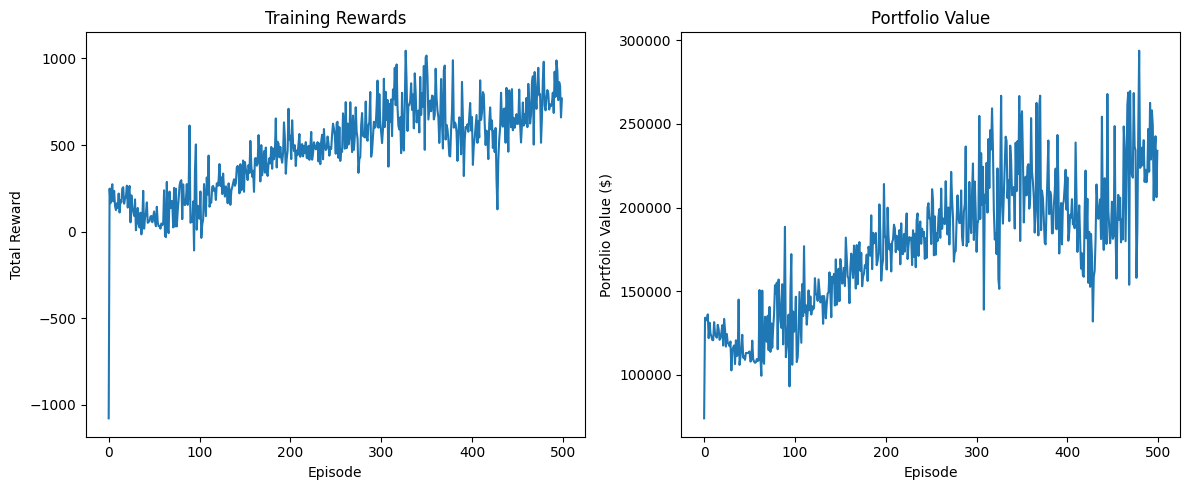

In [15]:

# Prepare data
df = prepare_data('CSCO')

# Create environment
env = TradingEnv(df)

# Create agent
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Train agent
rewards_history, portfolio_history, best_state_dict = train_agent(env, agent, episodes=500)

agent.policy_net.load_state_dict(best_state_dict)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards_history)
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.plot(portfolio_history)
plt.title('Portfolio Value')
plt.xlabel('Episode')
plt.ylabel('Portfolio Value ($)')

plt.tight_layout()
plt.show()

    # Run the visualization with benchmark comparison

In [16]:
def visualize_trades_with_benchmark(env, agent, df):
    # Run agent strategy
    state = env.reset()
    done = False
    
    buy_dates = []
    sell_dates = []
    portfolio_values = [env.balance]
    initial_balance = env.balance
    dates = df.index
    current_step = 0
    shares_held = []
    actions = [[], []]
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        
        if action == 2:  # Buy
            buy_dates.append(dates[current_step])
        elif action == 0:  # Sell
            sell_dates.append(dates[current_step])
            
        portfolio_values.append(info['portfolio_value'])
        shares_held.append(info['shares_held'] / (info['max_shares_held']) if shares_held else info['shares_held'])

        state = next_state
        current_step += 1
        actions[0].append(action)
        actions[1].append(0)  # Assuming single action dimension for simplicity
    
    shares_held[0] = 0.5
    
    # Calculate buy-and-hold strategy
    initial_stock_price = df['Close'].iloc[0]
    num_shares_buyhold = 2*initial_balance / initial_stock_price
    buyhold_values = df['Close'] * num_shares_buyhold 
    
    # Create subplots
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), height_ratios=[1.5, 1, 1.5, 1])
    
    # Plot 1: Stock price with buy/sell points
    ax1.plot(dates, df['Close'], label='Stock Price', alpha=0.7)
    ax1.scatter(buy_dates, df.loc[buy_dates]['Close'], color='green', marker='^', label='Buy', s=100)
    ax1.scatter(sell_dates, df.loc[sell_dates]['Close'], color='red', marker='v', label='Sell', s=100)
    ax1.set_title('Stock Price with Trading Signals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Portfolio Value Comparison
    ax2.plot(dates[1:len(portfolio_values)], portfolio_values[1:], label='Agent Strategy', color='blue')
    ax2.plot(dates[1:], buyhold_values[1:], label='Buy and Hold Strategy', color='orange', alpha=0.7)
    ax2.set_title('Portfolio Value Comparison')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Value ($)')
    ax2.legend()
    ax2.grid(True)

    # Plot 3: Stock Holdings
    ax3.plot(dates[:len(shares_held)], shares_held, label='Shares Held')
    ax3.set_title('Stock Holdings Over Time')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Stock Holdings')
    ax3.legend()
    ax3.grid(True)

    # Plot 4: Actions Taken
    for size in range(3):  # Assuming 3 action types: Sell, Hold, Buy
        mask = np.array(actions[0]) == size
        ax4.scatter(np.array(dates[:len(actions[0])])[mask], np.array(actions[0])[mask], label=f'Action {size}', alpha=0.7)
    
    ax4.set_title('Actions Taken Over Time')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Action Type')
    ax4.set_yticks([0, 1, 2])
    ax4.set_yticklabels(['Sell', 'Hold', 'Buy'])
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print statistics
    agent_final_value = portfolio_values[-1]
    buyhold_final_value = buyhold_values.iloc[-1]
    
    agent_return = ((agent_final_value - initial_balance) / initial_balance) * 100
    buyhold_return = ((buyhold_final_value - initial_balance) / initial_balance) * 100
    
    print("\n=== Performance Comparison ===")
    print(f"Initial Investment: ${initial_balance:,.2f}")
    print("\nAgent Strategy:")
    print(f"Final Value: ${agent_final_value:,.2f}")
    print(f"Total Return: {agent_return:.2f}%")
    print(f"Number of Trades: {len(buy_dates) + len(sell_dates)}")
    
    print("\nBuy and Hold Strategy:")
    print(f"Final Value: ${buyhold_final_value:,.2f}")
    print(f"Total Return: {buyhold_return:.2f}%")
    
    # Calculate additional metrics
    agent_values = np.array(portfolio_values)
    agent_returns = np.diff(agent_values) / agent_values[:-1]
    buyhold_returns = buyhold_values.pct_change().dropna()
    
    agent_sharpe = np.sqrt(252) * np.mean(agent_returns) / np.std(agent_returns)
    buyhold_sharpe = np.sqrt(252) * np.mean(buyhold_returns) / np.std(buyhold_returns)
    
    # Maximum drawdown calculation
    agent_peak = np.maximum.accumulate(agent_values)
    agent_drawdown = (agent_peak - agent_values) / agent_peak
    agent_max_drawdown = np.max(agent_drawdown) * 100
    
    buyhold_peak = np.maximum.accumulate(buyhold_values)
    buyhold_drawdown = (buyhold_peak - buyhold_values) / buyhold_peak
    buyhold_max_drawdown = np.max(buyhold_drawdown) * 100
    
    print("\nRisk Metrics:")
    print(f"Agent Sharpe Ratio: {agent_sharpe:.2f}")
    print(f"Buy-Hold Sharpe Ratio: {buyhold_sharpe:.2f}")
    print(f"Agent Maximum Drawdown: {agent_max_drawdown:.2f}%")
    print(f"Buy-Hold Maximum Drawdown: {buyhold_max_drawdown:.2f}%")


# Mulitple Stock training


In [40]:
# Usage example:
symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
data_dict = prepare_multiple_data(symbols)

# Create environment with multiple stocks
env = MultiStockTradingEnv(data_dict)

# Create agent with modified state size
state_size = env.observation_space.shape[0]
action_size = 3  # Still 3 actions per stock
agent = DQNAgent(state_size, env.n_stocks * action_size)

# Train agent
rewards_history, portfolio_history, best_state_dict = train_agent(env, agent, episodes=500)

New best reward! Portfolio Value: 270217.3139490663 Total Reward: 0.38256464463495965
Episode: 10, Reward: -12.87, Portfolio Value: $289681.18, Epsilon: 0.01
Episode: 20, Reward: -21.76, Portfolio Value: $291446.90, Epsilon: 0.01
Episode: 30, Reward: -21.79, Portfolio Value: $291833.17, Epsilon: 0.01
Episode: 40, Reward: -53.98, Portfolio Value: $242326.50, Epsilon: 0.01
Episode: 50, Reward: -1.85, Portfolio Value: $288833.06, Epsilon: 0.01
Episode: 60, Reward: -5.20, Portfolio Value: $287173.76, Epsilon: 0.01
Episode: 70, Reward: -13.36, Portfolio Value: $287469.03, Epsilon: 0.01
Episode: 80, Reward: -6.26, Portfolio Value: $287873.11, Epsilon: 0.01
Episode: 90, Reward: -6.65, Portfolio Value: $287565.53, Epsilon: 0.01
Episode: 100, Reward: -12.12, Portfolio Value: $290475.43, Epsilon: 0.01
Episode: 110, Reward: 1.08, Portfolio Value: $251151.85, Epsilon: 0.01
New best reward! Portfolio Value: 251151.8480379181 Total Reward: 1.081295587273586
Episode: 120, Reward: -6.64, Portfolio Val

In [43]:
def visualize_multi_stock_trades(env, agent, data_dict):
    state = env.reset()
    done = False
    
    portfolio_values = []
    actions_history = {symbol: [] for symbol in env.symbols}
    dates = list(data_dict[env.symbols[0]].index)
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)

        symbol = env.symbols[action // env.n_stocks]
        action_int = action % env.n_stocks
        
        # Record actions for each stock
        
        actions_history[symbol].append(action_int)
        for symbols in env.symbols:
            if symbols != symbol:
                actions_history[symbols].append(-1)
        
        portfolio_values.append(info['portfolio_value'])
        state = next_state
    
    # Create visualization
    fig, axes = plt.subplots(len(env.symbols) + 1, 1, figsize=(15, 5*len(env.symbols)))
    
    # Plot portfolio value
    axes[0].plot(dates[:len(portfolio_values)], portfolio_values)
    axes[0].set_title('Total Portfolio Value')
    
    # Plot individual stock prices and actions
    for i, symbol in enumerate(env.symbols):
        ax = axes[i+1]
        df = data_dict[symbol]
        ax.plot(dates, df['Close'], label=f'{symbol} Price')
        
        # Plot buy/sell points
        for j, action in enumerate(actions_history[symbol]):
            if action == 2:  # Buy
                ax.scatter(dates[j], df['Close'].iloc[j], color='green', marker='^')
            elif action == 0:  # Sell
                ax.scatter(dates[j], df['Close'].iloc[j], color='red', marker='v')
        
        ax.set_title(f'{symbol} Trading Activity')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

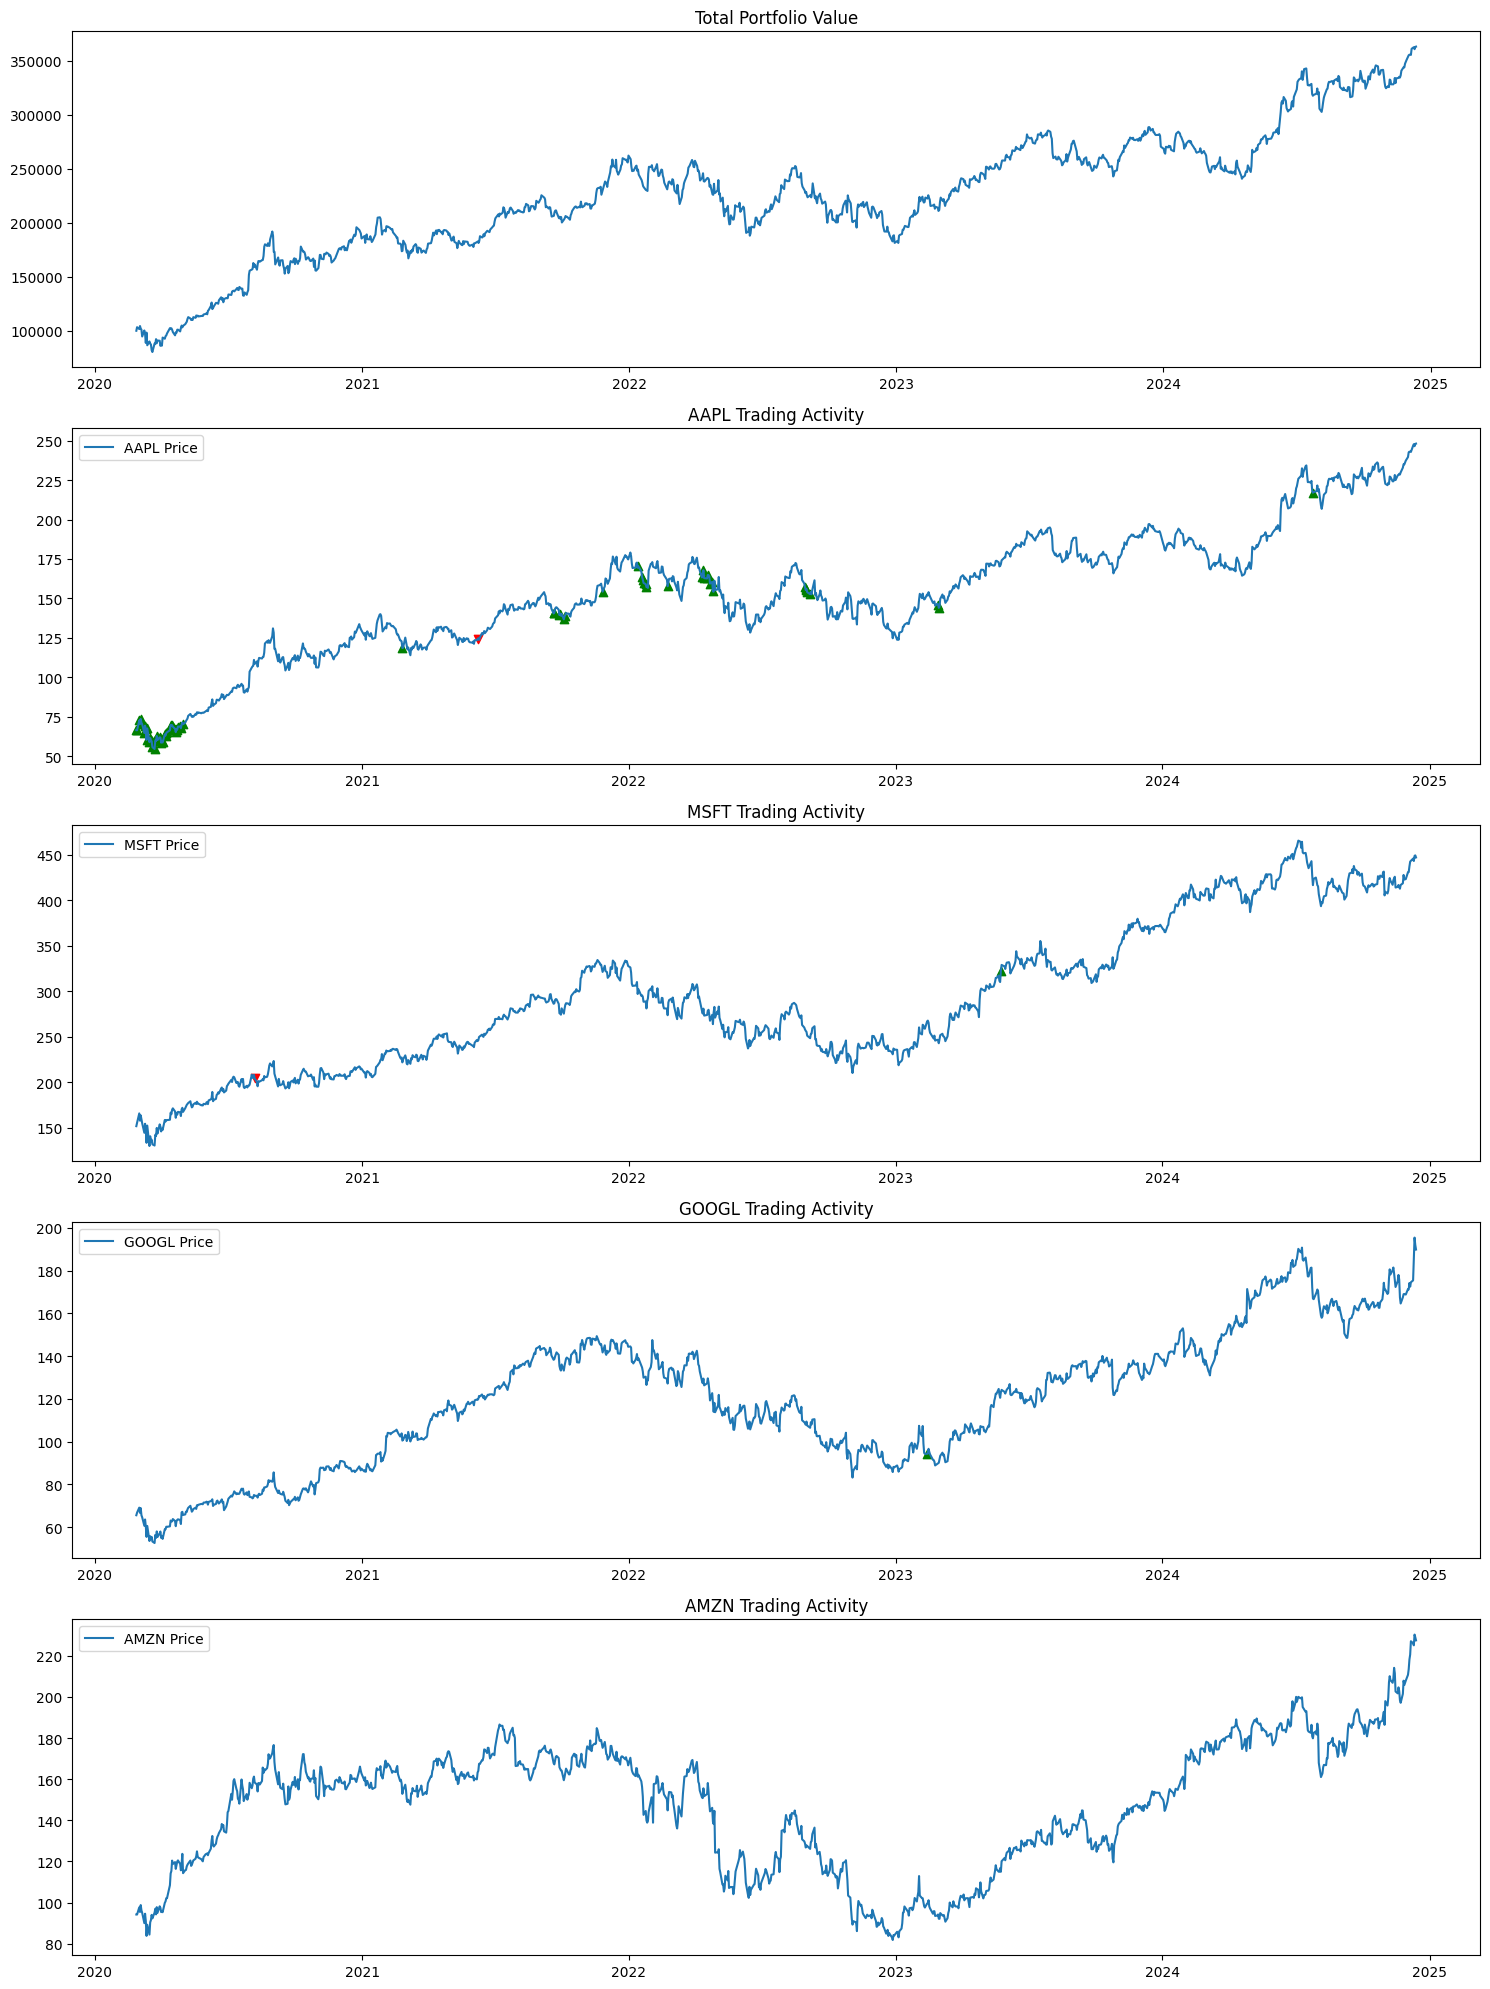

In [44]:
visualize_multi_stock_trades(env, agent, data_dict)

                                Open       High        Low      Close  \
Date                                                                    
2020-02-27 00:00:00-05:00  68.292072  69.482505  66.314490  66.450539   
2020-02-28 00:00:00-05:00  62.500252  67.638555  62.284027  66.411674   
2020-03-02 00:00:00-05:00  68.578756  73.233599  67.470923  72.594650   
2020-03-03 00:00:00-05:00  73.775383  73.855552  69.433934  70.289108   
2020-03-04 00:00:00-05:00  72.018860  73.709761  71.214710  73.549416   

                              Volume  Dividends  Stock Splits        RSI  \
Date                                                                       
2020-02-27 00:00:00-05:00  320605600        0.0           0.0  20.962695   
2020-02-28 00:00:00-05:00  426510000        0.0           0.0  22.030531   
2020-03-02 00:00:00-05:00  341397200        0.0           0.0  39.409492   
2020-03-03 00:00:00-05:00  319475600        0.0           0.0  36.820190   
2020-03-04 00:00:00-05:00  21917

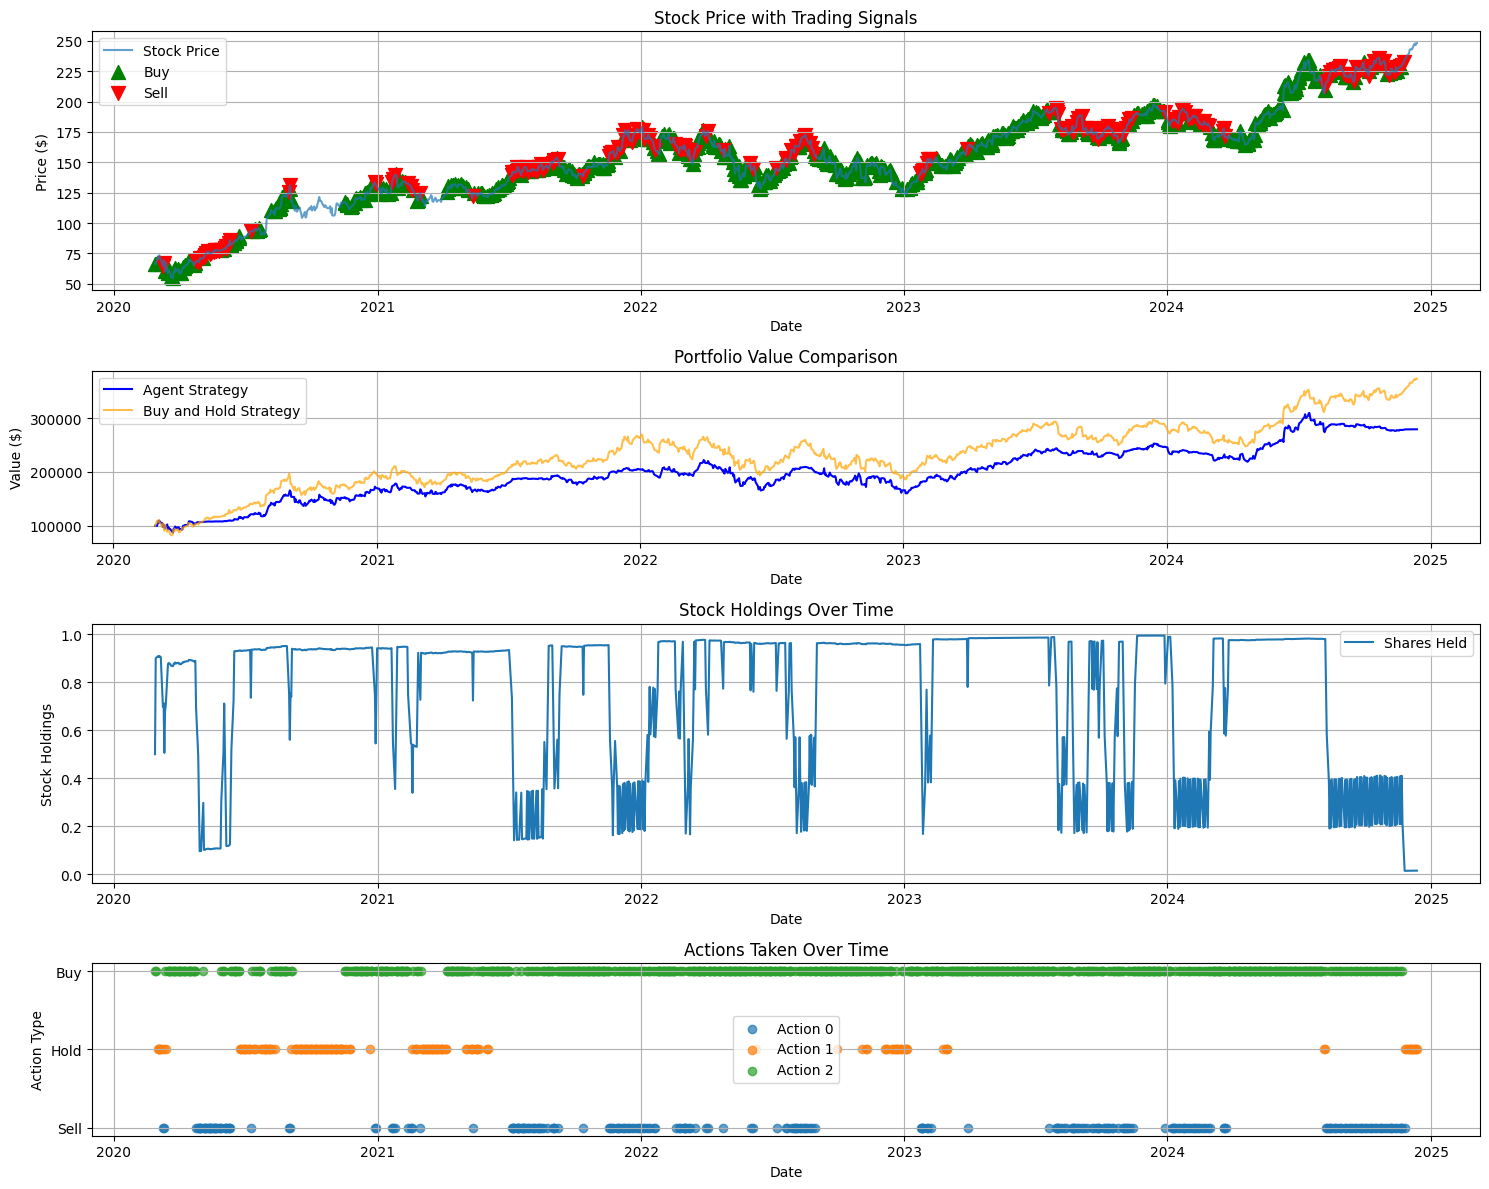


=== Performance Comparison ===
Initial Investment: $50,029.19

Agent Strategy:
Final Value: $279,298.14
Total Return: 458.27%
Number of Trades: 1046

Buy and Hold Strategy:
Final Value: $373,623.59
Total Return: 646.81%

Risk Metrics:
Agent Sharpe Ratio: 0.87
Buy-Hold Sharpe Ratio: 1.03
Agent Maximum Drawdown: 27.93%
Buy-Hold Maximum Drawdown: 30.91%


In [20]:
df = prepare_data('AAPL')

# Create environment
env = TradingEnv(df)

visualize_trades_with_benchmark(env, agent, df)

                                Open       High        Low      Close  \
Date                                                                    
2020-02-27 00:00:00-05:00  35.583489  36.290331  34.488744  34.514606   
2020-02-28 00:00:00-05:00  33.359521  34.954226  33.057818  34.419785   
2020-03-02 00:00:00-05:00  34.609426  35.505907  33.549160  35.488667   
2020-03-03 00:00:00-05:00  35.566248  36.117933  34.230144  34.514606   
2020-03-04 00:00:00-05:00  35.100777  35.730039  34.307733  35.678318   

                             Volume  Dividends  Stock Splits        RSI  \
Date                                                                      
2020-02-27 00:00:00-05:00  51442900        0.0           0.0  18.407523   
2020-02-28 00:00:00-05:00  80188000        0.0           0.0  19.265953   
2020-03-02 00:00:00-05:00  48864300        0.0           0.0  21.311419   
2020-03-03 00:00:00-05:00  49294700        0.0           0.0  18.194465   
2020-03-04 00:00:00-05:00  30022100   

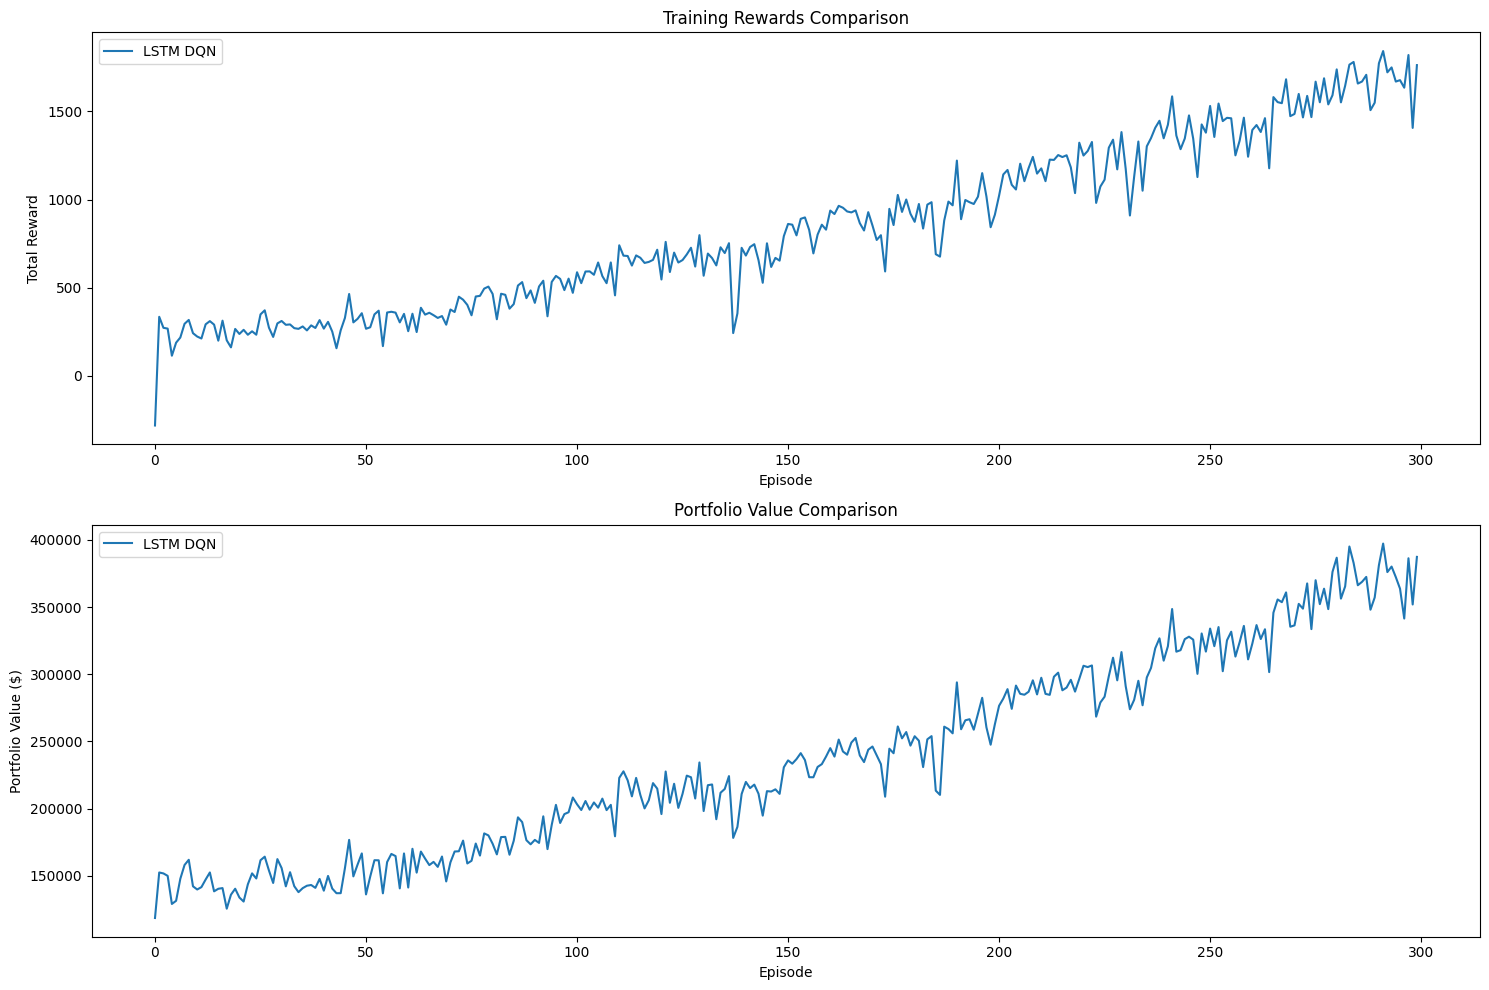


Final Statistics:

LSTM DQN:
Final Reward: 1763.03
Final Portfolio Value: $387330.95
Average Reward: 833.27
Average Portfolio Value: $237115.90


In [18]:
# First, let's create different neural network architectures
class StandardDQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(StandardDQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

class DuelingDQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DuelingDQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )
        
        self.value = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        feature = self.feature(x)
        advantage = self.advantage(feature)
        value = self.value(feature)
        return value + advantage - advantage.mean(dim=1, keepdim=True)

class LSTMDQN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64, num_layers=2):
        super(LSTMDQN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, output_size)
        
    def forward(self, x):
        # Reshape input for LSTM if necessary
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        
        lstm_out, _ = self.lstm(x)
        x = F.relu(self.fc1(lstm_out[:, -1, :]))  # Take only the last output
        return self.fc2(x)

# Modified Agent class to support different architectures
class EnhancedDQNAgent:
    def __init__(self, state_size, action_size, model_type='standard', 
                 device='cuda' if torch.cuda.is_available() else 'cpu',
                 gamma=0.99, epsilon=1.0, epsilon_min=0.01, 
                 epsilon_decay=0.995, learning_rate=0.001, 
                 batch_size=64, update_target_freq=10):
        
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        self.memory = ReplayBuffer(100000)
        self.model_type = model_type
        
        # Hyperparameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.update_target_freq = update_target_freq
        self.train_step = 0
        
        # Initialize networks based on model type
        if model_type == 'standard':
            self.policy_net = StandardDQN(state_size, action_size).to(device)
            self.target_net = StandardDQN(state_size, action_size).to(device)
        elif model_type == 'dueling':
            self.policy_net = DuelingDQN(state_size, action_size).to(device)
            self.target_net = DuelingDQN(state_size, action_size).to(device)
        elif model_type == 'lstm':
            self.policy_net = LSTMDQN(state_size, action_size).to(device)
            self.target_net = LSTMDQN(state_size, action_size).to(device)
        
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
    
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state)
            return q_values.argmax().item()
    
    def train(self):
        if len(self.memory) < self.batch_size:
            return
        
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Get current Q values
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # Compute target Q values differently for Double DQN
        if self.model_type == 'double':
            next_actions = self.policy_net(next_states).max(1)[1].unsqueeze(1)
            next_q_values = self.target_net(next_states).gather(1, next_actions).squeeze(1)
        else:
            next_q_values = self.target_net(next_states).max(1)[0]
        
        expected_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        
        # Compute loss and optimize
        loss = F.smooth_l1_loss(current_q_values.squeeze(), expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network
        self.train_step += 1
        if self.train_step % self.update_target_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        return loss.item()

# Function to compare different models
def compare_models(env, episodes=100):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    
    models = {
        'Standard DQN': EnhancedDQNAgent(state_size, action_size, model_type='standard'),
        'Dueling DQN': EnhancedDQNAgent(state_size, action_size, model_type='dueling'),
        'LSTM DQN': EnhancedDQNAgent(state_size, action_size, model_type='lstm')
    }
    
    results = {}
    
    for model_name, agent in models.items():
        print(f"\nTraining {model_name}...")
        rewards_history, portfolio_history, _ = train_agent(env, agent, episodes=episodes)
        results[model_name] = {
            'rewards': rewards_history,
            'portfolio': portfolio_history
        }
    
    # Plot comparison results
    plt.figure(figsize=(15, 10))
    
    # Plot rewards
    plt.subplot(2, 1, 1)
    for model_name, data in results.items():
        plt.plot(data['rewards'], label=model_name)
    plt.title('Training Rewards Comparison')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    
    # Plot portfolio values
    plt.subplot(2, 1, 2)
    for model_name, data in results.items():
        plt.plot(data['portfolio'], label=model_name)
    plt.title('Portfolio Value Comparison')
    plt.xlabel('Episode')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print final statistics
    print("\nFinal Statistics:")
    for model_name, data in results.items():
        final_reward = data['rewards'][-1]
        final_portfolio = data['portfolio'][-1]
        print(f"\n{model_name}:")
        print(f"Final Reward: {final_reward:.2f}")
        print(f"Final Portfolio Value: ${final_portfolio:.2f}")
        print(f"Average Reward: {np.mean(data['rewards']):.2f}")
        print(f"Average Portfolio Value: ${np.mean(data['portfolio']):.2f}")
    
    return results

df = prepare_data('CSCO')  # or any other stock
env = TradingEnv(df)
results = compare_models(env, episodes=300)

# LSTM DQN

                                Open       High        Low      Close  \
Date                                                                    
2020-02-27 00:00:00-05:00  35.583496  36.290339  34.488752  34.514614   
2020-02-28 00:00:00-05:00  33.359517  34.954222  33.057814  34.419781   
2020-03-02 00:00:00-05:00  34.609434  35.505915  33.549167  35.488674   
2020-03-03 00:00:00-05:00  35.566256  36.117941  34.230151  34.514614   
2020-03-04 00:00:00-05:00  35.100774  35.730036  34.307729  35.678314   

                             Volume  Dividends  Stock Splits        RSI  \
Date                                                                      
2020-02-27 00:00:00-05:00  51442900        0.0           0.0  18.407598   
2020-02-28 00:00:00-05:00  80188000        0.0           0.0  19.266036   
2020-03-02 00:00:00-05:00  48864300        0.0           0.0  21.311625   
2020-03-03 00:00:00-05:00  49294700        0.0           0.0  18.194619   
2020-03-04 00:00:00-05:00  30022100   

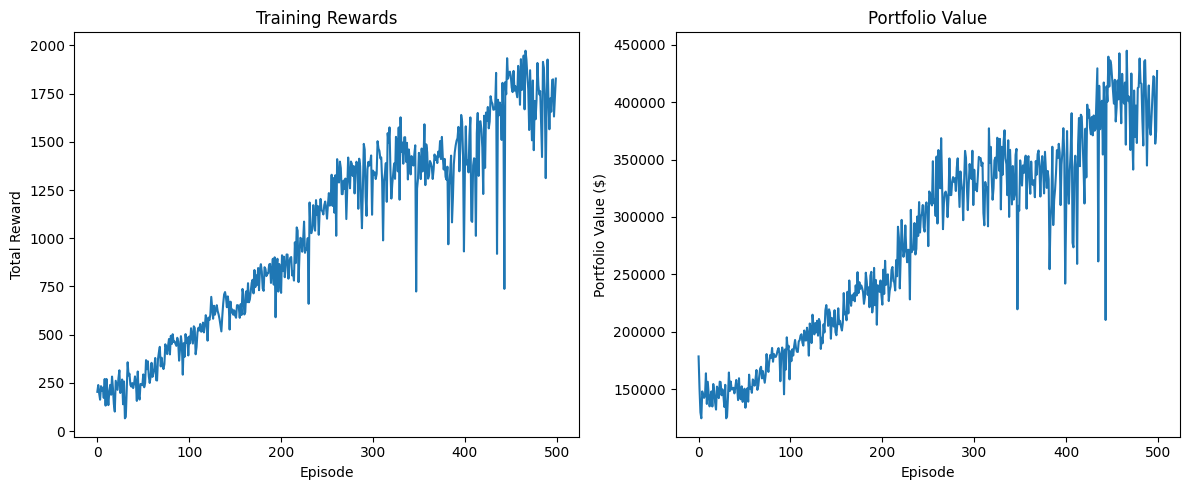

                                Open       High        Low      Close  \
Date                                                                    
2020-02-27 00:00:00-05:00  35.583492  36.290335  34.488748  34.514610   
2020-02-28 00:00:00-05:00  33.359525  34.954229  33.057822  34.419788   
2020-03-02 00:00:00-05:00  34.609437  35.505918  33.549170  35.488678   
2020-03-03 00:00:00-05:00  35.566252  36.117937  34.230148  34.514610   
2020-03-04 00:00:00-05:00  35.100774  35.730036  34.307729  35.678314   

                             Volume  Dividends  Stock Splits        RSI  \
Date                                                                      
2020-02-27 00:00:00-05:00  51442900        0.0           0.0  18.407563   
2020-02-28 00:00:00-05:00  80188000        0.0           0.0  19.266001   
2020-03-02 00:00:00-05:00  48864300        0.0           0.0  21.311542   
2020-03-03 00:00:00-05:00  49294700        0.0           0.0  18.194600   
2020-03-04 00:00:00-05:00  30022100   

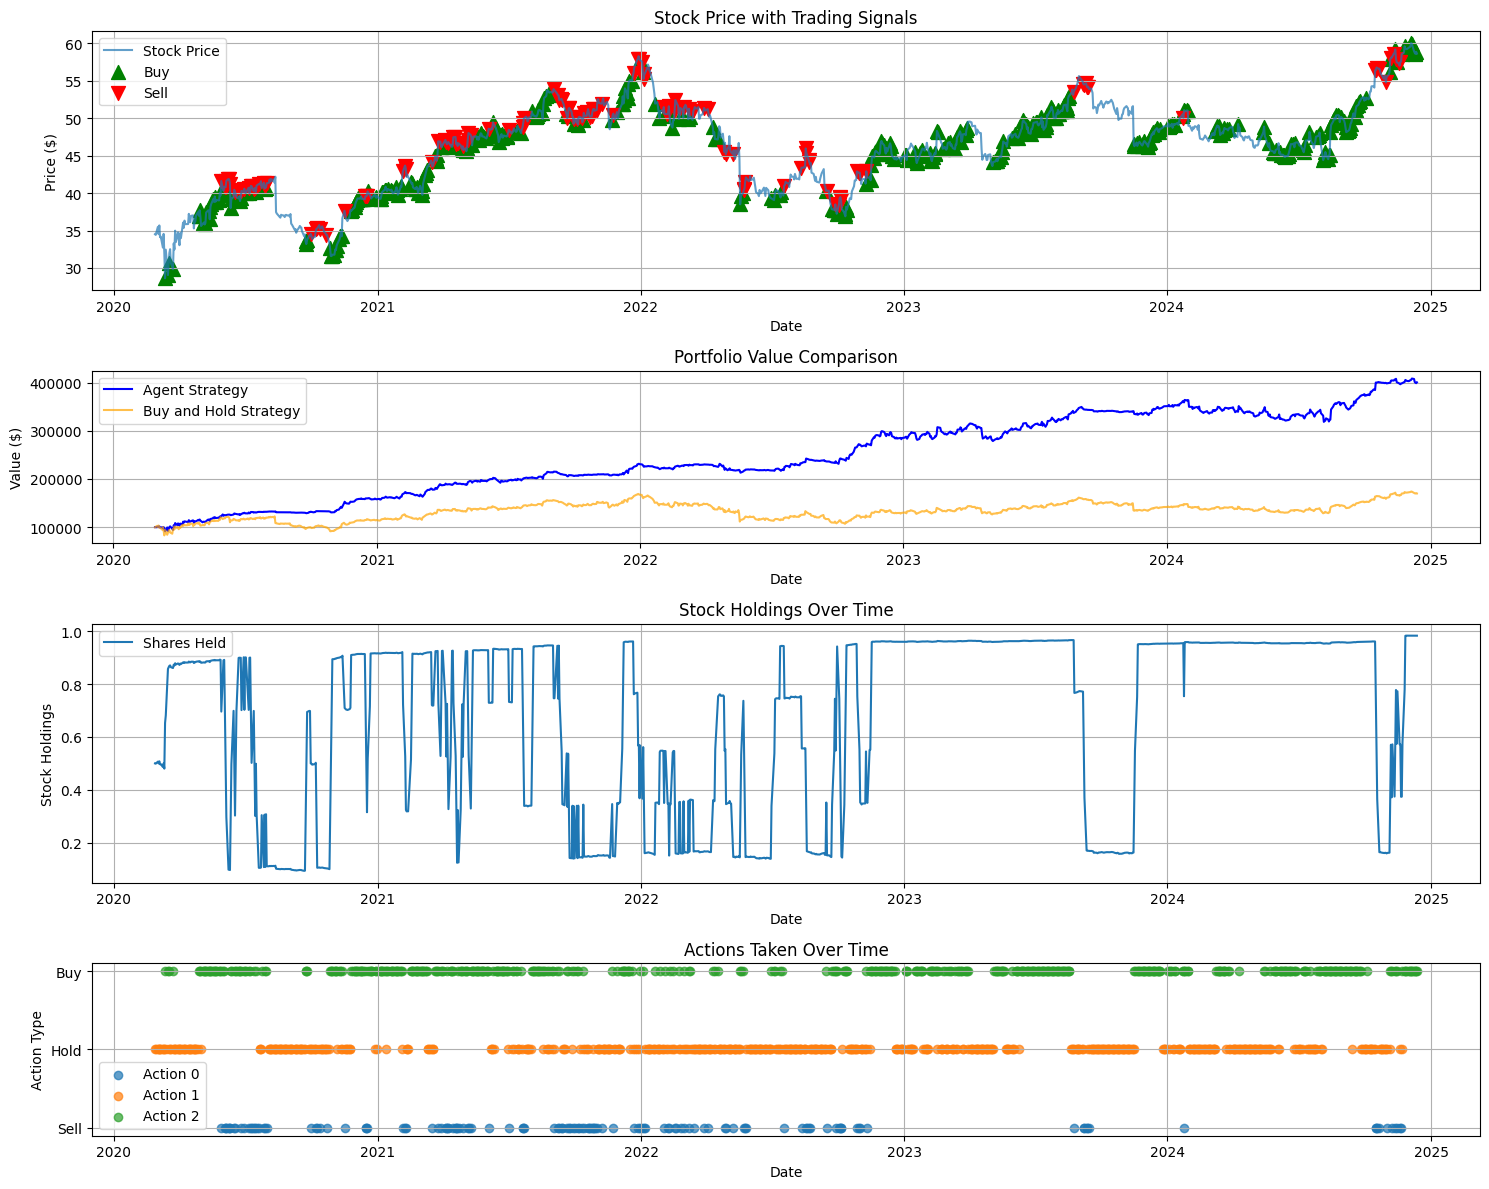


=== Performance Comparison ===
Initial Investment: $50,022.84

Agent Strategy:
Final Value: $400,388.24
Total Return: 700.41%
Number of Trades: 642

Buy and Hold Strategy:
Final Value: $169,918.71
Total Return: 239.68%

Risk Metrics:
Agent Sharpe Ratio: 1.05
Buy-Hold Sharpe Ratio: 0.54
Agent Maximum Drawdown: 12.53%
Buy-Hold Maximum Drawdown: 36.68%
                                Open       High        Low      Close  \
Date                                                                    
2020-02-27 00:00:00-05:00  68.292096  69.482529  66.314512  66.450562   
2020-02-28 00:00:00-05:00  62.500245  67.638548  62.284020  66.411667   
2020-03-02 00:00:00-05:00  68.578748  73.233591  67.470916  72.594643   
2020-03-03 00:00:00-05:00  73.775359  73.855528  69.433911  70.289085   
2020-03-04 00:00:00-05:00  72.018875  73.709776  71.214725  73.549431   

                              Volume  Dividends  Stock Splits        RSI  \
Date                                                       

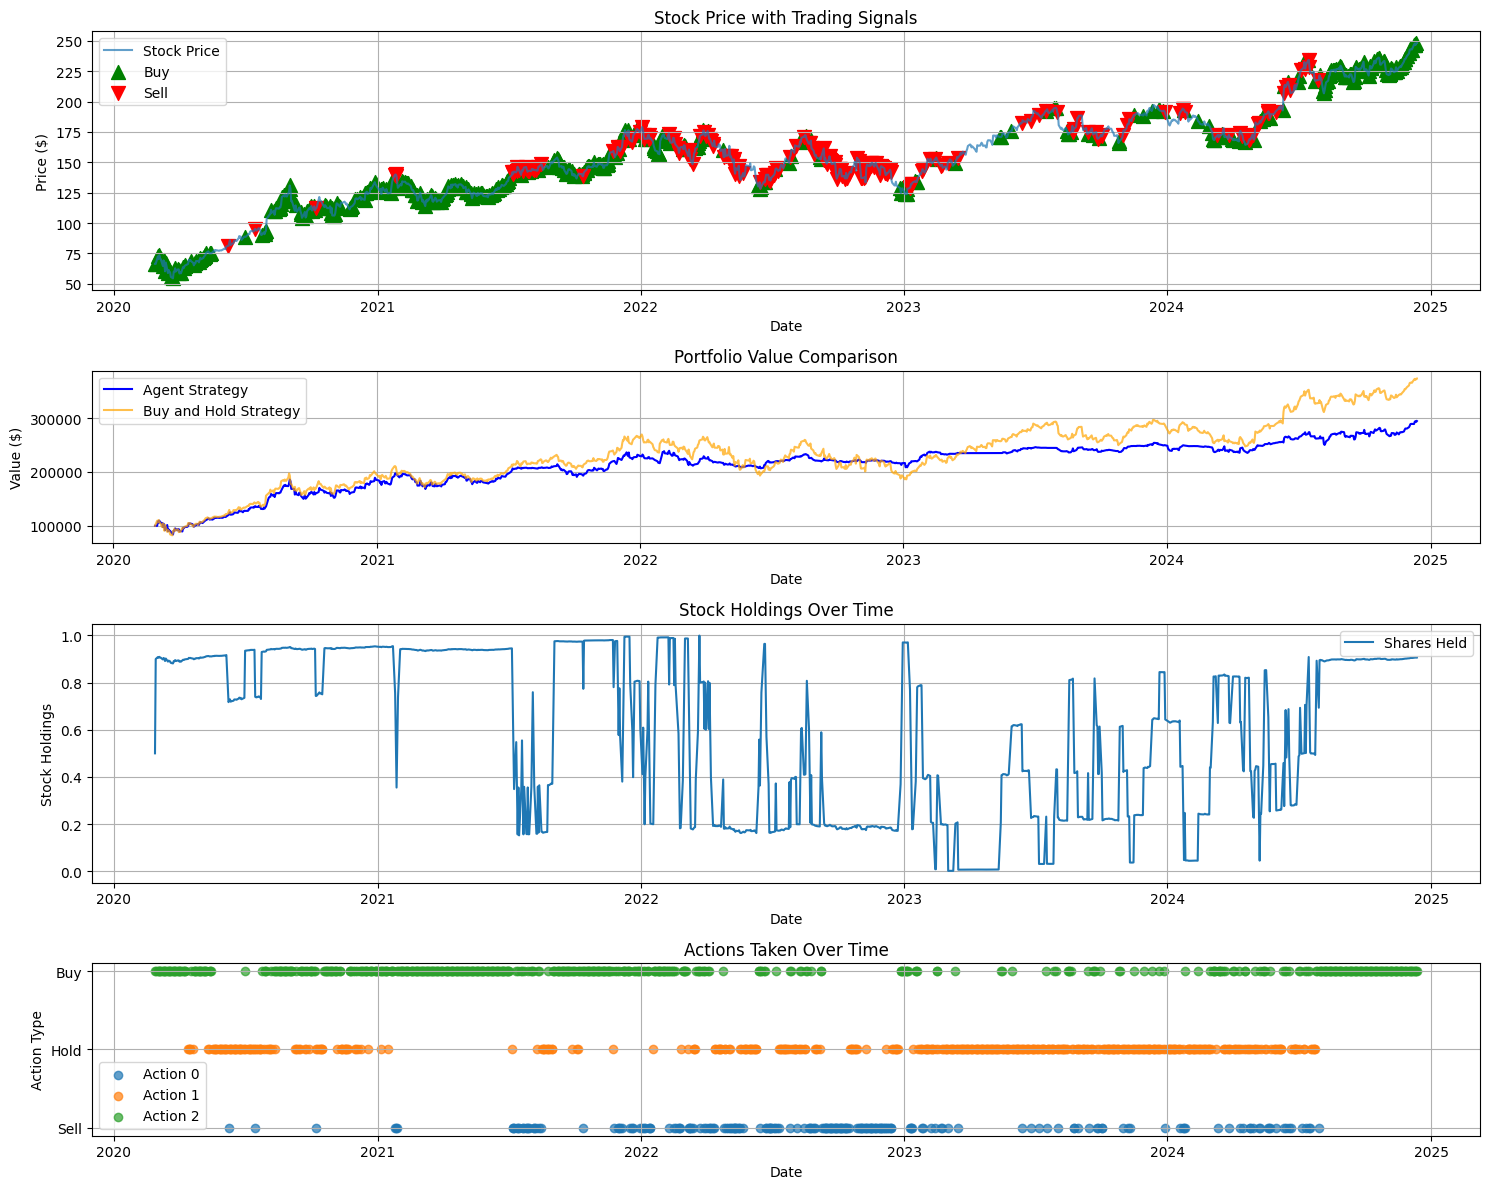


=== Performance Comparison ===
Initial Investment: $50,029.18

Agent Strategy:
Final Value: $294,624.94
Total Return: 488.91%
Number of Trades: 758

Buy and Hold Strategy:
Final Value: $373,623.33
Total Return: 646.81%

Risk Metrics:
Agent Sharpe Ratio: 0.90
Buy-Hold Sharpe Ratio: 1.03
Agent Maximum Drawdown: 23.54%
Buy-Hold Maximum Drawdown: 30.91%


In [45]:

# Prepare data
df = prepare_data('CSCO')

# Create environment
env = TradingEnv(df)

# Create agent
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = EnhancedDQNAgent(state_size, action_size, model_type='lstm')

# Train agent
rewards_history, portfolio_history, best_state_dict = train_agent(env, agent, episodes=500)

agent.policy_net.load_state_dict(best_state_dict)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards_history)
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.plot(portfolio_history)
plt.title('Portfolio Value')
plt.xlabel('Episode')
plt.ylabel('Portfolio Value ($)')

plt.tight_layout()
plt.show()

df = prepare_data('CSCO')

# Create environment
env = TradingEnv(df)

visualize_trades_with_benchmark(env, agent, df)

df = prepare_data('AAPL')

# Create environment
env = TradingEnv(df)

visualize_trades_with_benchmark(env, agent, df)

    # Run the visualization with benchmark comparison

In [46]:
import itertools
import datetime
import json
import csv
import os

def grid_search(env, state_size, action_size, param_grid, episodes=300):
    # Create logs directory if it doesn't exist
    if not os.path.exists('logs'):
        os.makedirs('logs')
    
    # Generate timestamp for file naming
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Create log files
    log_file = f'logs/grid_search_{timestamp}.csv'
    best_params_file = f'logs/best_params_{timestamp}.json'
    
    best_reward = -float('inf')
    best_params = None
    best_state_dict = None
    
    # Setup CSV logger
    with open(log_file, 'w', newline='') as f:
        writer = csv.writer(f)
        # Write header
        header = list(param_grid.keys()) + ['total_reward', 'avg_reward']
        writer.writerow(header)
        
        # Generate all combinations of hyperparameters
        keys, values = zip(*param_grid.items())
        for param_combination in itertools.product(*values):
            params = dict(zip(keys, param_combination))
            
            print(f"\nTesting parameters: {params}")
            
            # Create a new agent with the current set of hyperparameters
            agent = DQNAgent(
                state_size=state_size,
                action_size=action_size,
                params=params
            )
            
            # Train the agent
            rewards_history, _, state_dict = train_agent(env, agent, episodes=episodes)
            
            # Calculate metrics
            total_reward = sum(rewards_history)
            avg_reward = total_reward / episodes
            
            # Log results
            row = [params[key] for key in param_grid.keys()] + [total_reward, avg_reward]
            writer.writerow(row)
            
            # Update best parameters if necessary
            if total_reward > best_reward:
                best_reward = total_reward
                best_params = params
                best_state_dict = state_dict
                
                # Save best model state
                torch.save(best_state_dict, f'logs/best_model_{timestamp}.pth')
    
    # Save best parameters to JSON
    best_results = {
        'best_params': best_params,
        'best_reward': float(best_reward),  # Convert to float for JSON serialization
        'timestamp': timestamp,
        'episodes': episodes
    }
    
    with open(best_params_file, 'w') as f:
        json.dump(best_results, f, indent=4)
    
    print(f"\nGrid search complete. Logs saved to: {log_file}")
    print(f"Best parameters saved to: {best_params_file}")
    print("\nBest Hyperparameters:", best_params)
    print("Best Reward:", best_reward)
    
    return best_params, best_reward, best_state_dict

# Define the hyperparameter grid
param_grid = {
    'gamma': [0.95, 0.99],
    'epsilon': [1.0],
    'epsilon_min': [0.01],
    'epsilon_decay': [0.995, 0.999],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32, 64]
}

# Run grid search
best_params, best_reward, best_state_dict = grid_search(env, state_size, action_size, param_grid)

# Load the best model
agent.policy_net.load_state_dict(best_state_dict)


Testing parameters: {'gamma': 0.95, 'epsilon': 1.0, 'epsilon_min': 0.01, 'epsilon_decay': 0.995, 'learning_rate': 0.001, 'batch_size': 32}
New best reward! Portfolio Value: 194417.47540619987 Total Reward: 292.4183883323326
New best reward! Portfolio Value: 221916.18289450085 Total Reward: 922.6839272028319
Episode: 10, Reward: 423.69, Portfolio Value: $164366.97, Epsilon: 0.01
Episode: 20, Reward: 380.08, Portfolio Value: $164247.70, Epsilon: 0.01
Episode: 30, Reward: 652.36, Portfolio Value: $201772.54, Epsilon: 0.01
Episode: 40, Reward: 169.64, Portfolio Value: $125942.09, Epsilon: 0.01
Episode: 50, Reward: 398.69, Portfolio Value: $164393.99, Epsilon: 0.01
Episode: 60, Reward: 198.76, Portfolio Value: $123521.76, Epsilon: 0.01
New best reward! Portfolio Value: 260009.56749299366 Total Reward: 1045.9120649324786
New best reward! Portfolio Value: 304192.94018866174 Total Reward: 1310.8828655172429
Episode: 70, Reward: 1120.68, Portfolio Value: $287164.75, Epsilon: 0.01
Episode: 80, 